# Introduction to CAD systems and image processing basic

## Teaching assistants

- Francesco Ciompi: francesco.ciompi@radboudumc.nl
- Bart Liefers: bart.liefers@radboudumc.nl

## Students
Please fill in this cell with your name and e-mail address. This information will be used to grade your assignment.

* Brigel Pineti, s1005549, b.pineti@student.ru.nl 
* Christoph Schmidl, s4226887, c.schmidl@student.ru.nl

## Instructions

* Groups: You should work in pairs or alone
* Deadline for this assignment: 
 * Sunday (February 11th) until midnight
 * 5 points (maximum grade = 100 points) penalization per day after deadline
* Send your **fully executed** notebook to: **francesco.ciompi@radboudumc.nl**
* The grades will be available before February 16th (tentative)

This notebooks contains cells with snippets of code that we provide in order to load and visualize data, but also some convenience functions that could be useful to develop your assingment.


We also provide templates for functions that have to be implemented, with a given list of input variables and some output variables. **Feel free to modify the input and output variables to adapt them to your favourite implementation.** However, this should at least provide the outputs required to develop the rest of the notebook.


Your submission should contain the **fully executed** notebook with **your code** implemented, as well as **your answers** to questions, which will be used to grade your assignment.

## Introduction

In this first assignment, we are going to implement and apply some basic image processing techniques, and we will get familiar with some kind of medical imaging data.
In particular, we will be working with data from:
* mammography (breast, 2D)
* histopathology (colon, 2D)
* chest CT (lungs, 3D)

We will implement the following techniques:
1. conversion of raw mammography data into a gray-scale image
2. stain normalization in digital pathology with histogram matching
3. trachea detection in chest CT with blob detection

## Libraries

First, we import the basic libraries necessary to develop this assignment. Feel free to include more libraries if needed.


In [1]:
import requests
import zipfile
from tqdm import tnrange, tqdm_notebook
import os
import SimpleITK as sitk
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline 
import numpy as np
from PIL import Image
import dicom
from IPython import display
import time
from mpl_toolkits.mplot3d import Axes3D
import copy
matplotlib.rcParams['figure.figsize'] = (20, 12)
import scipy.signal

### Data

The data necessary to develop the code in this assignment can be downloaded by executing the next cell (SHIFT+ENTER on the selected cell).
All data used in this assignment, as well as in all assignments of this course, are publicly available, and mostly 
Data are stored in a public folder on SURFDrive.
This will download and uncompress data contained in the file ```assignment_1.zip``` to a folder ```/your_notebook_directory/assignment_1```. After the file is unzipped, it is removed.

Run the next cell and wait until the progress bar becomes green.
On a decent network connection it should take ~1 minute.

In [2]:
link = 'https://surfdrive.surf.nl/files/index.php/s/rkeR7v9GdxejBOE/download'
file_name = "assignment_1.zip"
with open(file_name, "wb") as f:
        response = requests.get(link, stream=True)
        total_length = response.headers.get('content-length')
        if total_length is None: # no content length header
            f.write(response.content)
        else:
            dl = 0
            total_length = int(total_length)
            for data in tqdm_notebook(response.iter_content(chunk_size=4096), desc='Downloading data'):
                dl += len(data)
                f.write(data)
with zipfile.ZipFile(file_name,"r") as zip_ref:
    zip_ref.extractall("./")
os.remove('./assignment_1.zip')

Check that the downloaded folder containes the following structure:
````
assignment_1
  |-LIDC-IDRI
    |-LIDC-IDRI-0001
      |-1.3.6.1.4.1.14519.5.2.1.6279.6001.298806137288633453246975630178
        |-1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636438705059720603192
          |-000001.dcm
          |-...
  |-CRC-Prim-HE-05_APPLICATION.tif
  |-CRC-Prim-HE-10_APPLICATION.tif
  |-processed_mammography.mhd
  |-processed_mammography.raw
  |-raw_mammography.mhd
  |-raw_mammography.raw
````

## 1. Gray-scale transformation of breast tomography (60 points)

The first assignment consists in reconstructing a gray-scale mammography image from the raw data acquired with the mammography machine. As we have seen in the lecture, there are several steps that have to be applied to reconstruct a gray-scale image that can actually be read by radiologists with the aim of detecting tumors, masses, cysts, micro-calcifications.

### Read image

In your local data folder, you can find a file containing raw mammography data and the corresponding processed gray-level version. The processed version comes from the vendor and is the result of several filtering and enhancement steps that are proprietary. Our goal is however to do a good job at deriving a gray-level image from raw data.
The files are in ITK format, with extension ````.mhd````, and can be opened using the library ````SimpleITK````. You can find documentation on ````SimpleITK```` at this link: http://www.simpleitk.org/SimpleITK/help/documentation.html.
In the next cell, we provide the function used to read the raw data and the gray-level images.
Furthermore, we indicate which steps have to be implemented.
Complete the assignment by implementing the steps indicated.

In [3]:
# raw and gray-level data in ITK format
raw_img_filename = './assignment_1/raw_mammography.mhd'
out_img_filename = './assignment_1/processed_mammography.mhd'

# read ITK files using SimpleITK
raw_img = sitk.ReadImage(raw_img_filename)
out_img = sitk.ReadImage(out_img_filename)

# print image information
print('image size: {}'.format(raw_img.GetSize()))
print('image origin: {}'.format(raw_img.GetOrigin()))
print('image spacing: {}'.format(raw_img.GetSpacing()))
print('image width: {}'.format(raw_img.GetWidth()))
print('image height: {}'.format(raw_img.GetHeight()))
print('image depth: {}'.format(raw_img.GetDepth()))

image size: (2560, 3328)
image origin: (0.0, 0.0)
image spacing: (0.07000000029802322, 0.07000000029802322)
image width: 2560
image height: 3328
image depth: 0


<font color="blue">
**Question:**
What is the pixel size of this image?
</font>

**Answer:** The raw_img image has a resolution of 2560 times 3328 (width times height) = 8519680 pixels in total. 

### Convert ITK image to Numpy array

In order to easily manipulate data, it is convenient to convert it into a numpy format, which can be transformed using the numpy library, and can easily be visualized using the ````pylab/matplotlib```` library.
Please check the documentation in http://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/Python_html/01_Image_Basics.html to find the proper function to transform the SimpleITK image to numpy. Write your code below:
* ````out_np````: should contain the numpy array from ````out_img````
* ````raw_np````: should contain the numpy array from ````raw_img````

Note: If you are not familiar with Numpy, you can check briefly this tutorial: http://cs231n.github.io/python-numpy-tutorial/

### NOTE
In the rest of this notebook, several cells will contain variables declared as ````None````.
This means that you have to replace ````None```` with your own code.
We have included checks using the ````assert()```` function to notifythat you cannot move to next cells without having replaced ````None```` with a valid expression. 

In [4]:
# convert the ITK image into numpy format
# >> YOUR CODE HERE <<<
out_np = sitk.GetArrayFromImage(out_img)
raw_np = sitk.GetArrayFromImage(raw_img)

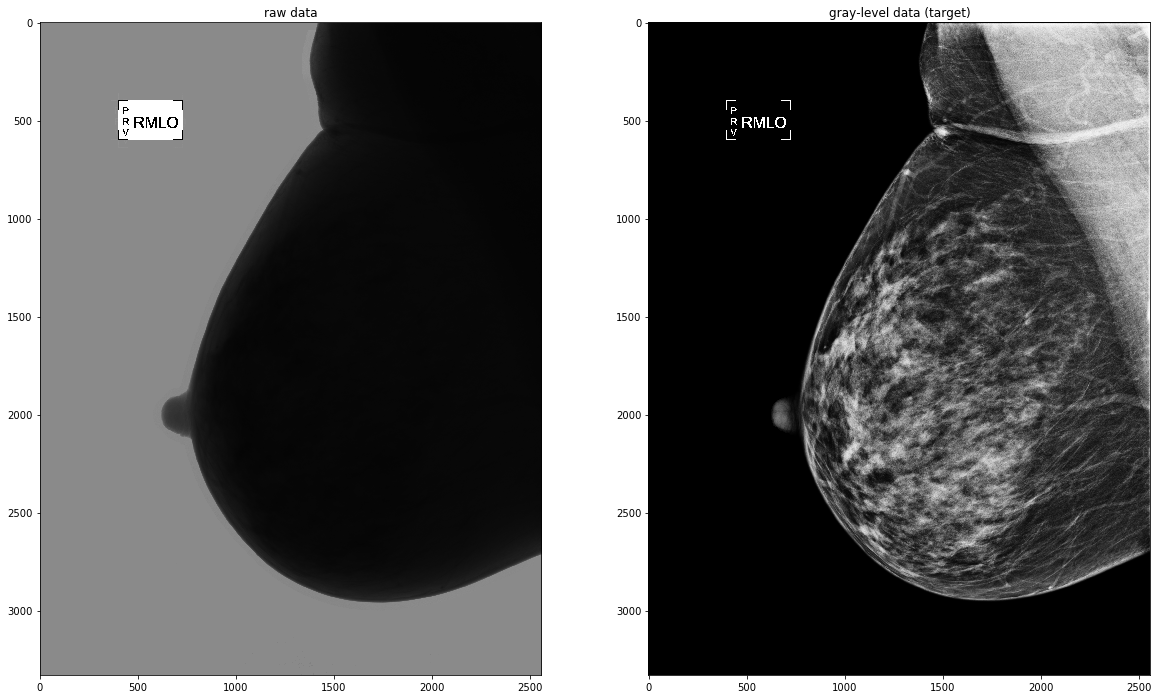

In [5]:
assert(out_np is not None),"out_np cannot be None"
assert(raw_np is not None),"raw_np cannot be None"

# visualize the two numpy arrays
plt.subplot(1,2,1)
plt.imshow(raw_np, cmap='gray')
plt.title('raw data')
plt.subplot(1,2,2)
plt.imshow(out_np, cmap='gray')
plt.title('gray-level data (target)')
plt.show()

### Image processing

Implement the three main steps necessary to convert raw data into a gray-level image:
1. Logaritmic transformation
2. Intensity inversion
3. Contrast stretching

Slide 24 of the previous lecture (part 2 of 3) shows this approach
<img src="images/raw2gray.png">

#### Logaritmic transformation

In [ ]:
# logarithmic transformation
# >> YOUR CODE HERE <<<
mammo_log = None

In [ ]:
assert(mammo_log is not None),"mammo_log cannot be None"

# visualize the result
plt.imshow(mammo_log, cmap='gray')
plt.title('after logaritmic transformation')

#### Intensity inversion

In [ ]:
# intensity inversion
# >> YOUR CODE HERE <<<
mammo_inv = None

In [ ]:
assert(mammo_inv is not None),"mammo_inv cannot be None"

# visualize the result
plt.imshow(mammo_inv, cmap='gray')
plt.title('after intensity inversion')

#### Contrast stretching

In order to apply the contrast stretching operation, let's first define a general contrast stretching function. The inputs should be at least (1) the input signal, (2) the window range values p0 and pk, as defined in the lecture.
**Note**: The end results should not contain intensity values larger than pk or lower than p0.

In [ ]:
# contrast stretching
def contrast_stretching(x, p0, pk, q0=0., qk=255.):
    # >>> YOUR CODE HERE <<<
    x_cs = None
    return x_cs

Now we can apply contrast stretching and visualize the result.

In [ ]:
# pick proper values for p0 and pk
p0 = None
pk = None

assert(p0 is not None),"p0 cannot be None"
assert(pk is not None),"pk cannot be None"

In [ ]:
mammo_cs = contrast_stretching(mammo_inv, p0, pk)
assert(mammo_cs is not None),"mammo_cs can not be None"

# visualize the result
plt.imshow(mammo_cs, cmap='gray')
plt.show()

You will notice that the result at this stage is already much more readable than the raw data you started from. However, the result is still not as good as the one provided by the mammography manufacturer. In order to check for the differences, we will visualize the histogram of the mammography after inversion (before contrast stretching), after contrast stretching and the target one.

In [ ]:
# visualize and compare histograms
plt.subplot(1,3,1)
plt.hist(mammo_inv.flatten(), 100)
plt.title('before contrast stretching')
plt.subplot(1,3,2)
plt.hist(mammo_cs.flatten(), 100)
plt.title('after contrast stretching')
plt.subplot(1,3,3)
plt.hist(out_np.flatten(), 100)
plt.title('target')
plt.show()

<font color="blue">
**Question:**
How did you define the values of p0 and pk? How much does the result change when this parameters sligthly change? Could you deduce this by having a look at the histogram?</font>

*Your answer here.*

#### Histogram equalization/matching instead of contrast stretching

The step of contrast stretching could be replaced by a histogram equalization step. In this way, we assume that the target image is known and accessible, from which we will learn some intensity value correspondance function, known as **look-up-table** (LUT). A LUT is a table that has entries that correspond to all possible values in the input image, and each value is mapped to an output value, with the aim of mimicking the intensity distribution of the target image, the vendor mammography in our case.

Implement a function that takes as input the histogram to transform and the target histogram and return a LUT.

In [ ]:
# function to do histogram matching
def get_histogram_matching_lut(h_input, h_template):
    ''' h_input: histogram to transfrom, h_template: reference'''
    if len(h_input) != len(h_template):
        print('histograms length mismatch!')
        return False
    
    # >> YOUR CODE HERE <<
    LUT = None
    H_input = None # Cumulative distribution of h_input
    H_template = None # Cumulative distribution of h_template
        
    return LUT, H_input, H_template

Now tha the function ````get_histogram_matching_lut()```` has been implemented, you can execute the next cell, which uses it, and visualize the result of the mammography image converted using histogram matching.

In [ ]:
# rescale images between [0,1]
out_np = out_np.astype(float)
mammo_inv_norm = (mammo_inv - mammo_inv.flatten().min())/(mammo_inv.flatten().max() - mammo_inv.flatten().min())
mammo_out_norm = (out_np - out_np.flatten().min())/(out_np.flatten().max() - out_np.flatten().min())

n_bins = None # define the number of bins
hist_inv = np.histogram(mammo_inv_norm, bins=np.linspace(0., 1., n_bins+1))
hist_out = np.histogram(mammo_out_norm, bins=np.linspace(0., 1., n_bins+1))

# compute LUT
LUT,H_input,H_template = get_histogram_matching_lut(hist_inv[0], hist_out[0])
assert(LUT        is not None),"LUT cannot be None"
assert(H_input    is not None),"H_input cannot be None"
assert(H_template is not None),"H_template cannot be None"

# histograms before matching
plt.suptitle('BEFORE HISTOGRAM MATCHING')
plt.subplot(1,2,1); plt.hist(mammo_inv_norm.flatten())
plt.title('histogram input')
plt.subplot(1,2,2); plt.hist(mammo_out_norm.flatten())
plt.title('histogram target')
plt.show()

# plot cumulative histogram
plt.suptitle('CUMULATIVE HISTOGRAMS')
plt.subplot(1,2,1); plt.plot(H_input)
plt.title('cumulative histogram input')
plt.subplot(1,2,2); plt.plot(H_template)
plt.title('cumulative histogram target')
plt.show()    
    
# apply histogram matching
mammo_lut = LUT[(mammo_inv_norm * (n_bins-1)).astype(int)]

# visual result
plt.suptitle('VISUAL RESULT')
plt.subplot(1,2,1); plt.imshow(mammo_lut.squeeze(), cmap='gray')
plt.title('converted image')
plt.subplot(1,2,2); plt.imshow(out_np, cmap='gray')
plt.title('target')
plt.show()

# histograms after matching
plt.suptitle('AFTER HISTOGRAM MATCHING')
plt.subplot(1,2,1)
plt.hist(mammo_lut.flatten())
plt.subplot(1,2,2)
plt.hist(out_np.flatten())
plt.show()

<font color="blue">**Question:**
How did you pick the number of bins to use to do histogram matching? Does the result depend on the number of bins?</font>

*Your answer here.*

## 2. Stain normalization with histogram matching (10 points)

<img src="./images/stain_examples.png" alt="HE1" style="width:200px" align="right">

In the previous exercise, we implemented a histogram matching function and used it to adapt a given mammography image to a given target image. In that case, the goal was to enhance relevant information in raw mammography data and make it visible as a gray-scale image.

The same technique can be applied to the field of digital pathology, but with the aim of solving a different problem, the *variability of stain* across images.
In pathology, tissue samples are cut and stained with specific dyes in order to enhance some tissues that are relevant for the diagnosis. The most commonly used staining is called Hematoxylyn and Eosin (H&E), which is routinely applied for diagnostic purposes.
The problem with H&E is that there is a large variability of stain across laboratories, and even in the same laboratory, when staining is done in different days of the week. This is because the final result strongly depends on the type and the density of the dyes and on the time the tissue is actually exposed to the dye.

The examples on the right are images of colorectal cancer tissue samples, extracted from a publicly available dataset (https://zenodo.org/record/53169#.WJRAC_krIuU), where the appearance, mainly the colour, of the HE-stained images, is different.
Histogram matching is a technique that can help solve this problem, since we can think of adapting the distribution of colors per channel (R,G,B) by treating each channel independently.

When working with digital pathology images, it is worth noting that the image size is often big. Typical histopathology images are gigapixel images (think of Google maps to get an indea) in the order of 100,000 x 100,000 pixel. However, for the sake of simplicity, in this assignment we will only use tiles of 5000x5000 px.

### Load the slides

In [ ]:
# load data
HE1 = np.asarray(Image.open('./assignment_1/CRC-Prim-HE-05_APPLICATION.tif'))
HE2 = np.asarray(Image.open('./assignment_1/CRC-Prim-HE-10_APPLICATION.tif'))

print(HE1.shape)
print(HE2.shape)

plt.subplot(1,2,1); plt.imshow(HE1); plt.title('HE1')
plt.subplot(1,2,2); plt.imshow(HE2); plt.title('HE2')

### Stain normalization

Implement your stain normalization function based on histogram matching based on the following definition.

In [ ]:
def stain_normalization(input_img, target_img, n_bins=100):
    """ Stain normalization based on histogram matching. """
    normalized_img = None
    # >> YOUR CODE HERE<<
    
    return normalized_img

Now we can use the implemented function to do stain normalization and check the actual result.

In [ ]:
# transform HE1 to match HE2
HE1_norm = stain_normalization(HE1, HE2);
assert(HE1_norm is not None),"HE1_norm can not be None"

plt.subplot(1,3,1)
plt.imshow(HE1); plt.title('HE1 before normalization')
plt.subplot(1,3,2)
plt.imshow(HE1_norm); plt.title('HE1 after normalization')
plt.subplot(1,3,3)
plt.imshow(HE2); plt.title('target')
plt.show()

# transform HE2 to match HE1
HE2_norm = stain_normalization(HE2, HE1);
plt.subplot(1,3,1); plt.imshow(HE2)
plt.title('HE2 before normalization')
plt.subplot(1,3,2); plt.imshow(HE2_norm)
plt.title('HE2 after normalization')
plt.subplot(1,3,3); plt.imshow(HE1)
plt.title('target')
plt.show()

## 3. Trachea detection in chest CT (30 points)

<img src="images/tracheaAxial.png"   align="right">

The last assignment is about automatic detection of the trachea in slices of a chest CT scan.
The detection of the trachea is often used as initialization of airway segmentation algorithms, where the position of the trachea is used as a seed point to grow segmentation methods.
For this purpose, we are going to develop a **blob detector** and process all slides of a given scan.
The idea is to implement an algorithm that reads an entire CT scan and returns the coordinates (x,y,z) of a point inside the trachea, which can be used as a reliable seed point for future analysis.
See the slice besides that shows where to find the trachea. For more images, visit:
- http://w-radiology.com/chest_ct.php
- http://w-radiology.com/chest_ct-parenchyma.php check it in Coronal view

### Loading DICOM

To develop our algorithm, we will use data from the publicly available dataset LIDC-IDRI (https://wiki.cancerimagingarchive.net/display/Public/LIDC-IDRI).
The database contains 1018 scans, but we will only use the first scan for this assignment, which you can find in the data folder.
The format of the chest CT file is DICOM, and for this we will need a dicom library in python (SimpleITK could also be used though).
The following code can be used to read all files in a given folder and to open one of those dicom files and convert it into a numpy array. 

In [ ]:
# function that reads all files in a directory
def get_file_list(path,ext='',queue=''):
    if ext != '': return [os.path.join(path,f) for f in os.listdir(path) if f.endswith(''+queue+'.'+ext+'')],  [f for f in os.listdir(path) if f.endswith(''+queue+'.'+ext+'')]    
    else: return [os.path.join(path,f) for f in os.listdir(path)]

In [ ]:
# load the first scan from LIDC-IDRI
scan_path = './assignment_1/LIDC-IDRI/LIDC-IDRI-0001/1.3.6.1.4.1.14519.5.2.1.6279.6001.298806137288633453246975630178/1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636438705059720603192'

# read all dicom files in the folder
dcm_files = sorted(get_file_list(scan_path, 'dcm')[0])
n_slices = len(dcm_files)

# read one slice and print dicom information
slice_idx = 0
ct_slice_dicom = dicom.read_file(dcm_files[slice_idx])
print(ct_slice_dicom)

# convert the slice to a numpy array
ct_slice_numpy = ct_slice_dicom.pixel_array
dims = ct_slice_numpy.shape

# print scan information
print('{} dicom files of dimension {} found'.format(n_slices, dims))

For convenience, we store all slices in a scan (3D) matrix

In [ ]:
scan = np.zeros((dims[0], dims[1], n_slices))
for f in range(n_slices):
    ds = dicom.read_file(dcm_files[f])
    scan[:,:,ds.InstanceNumber-1] = ds.pixel_array
print(scan.shape)

### Seed point detection

<img src="images/gaussian.gif" align="right" width="250">


A blob detector is based on a Gaussian function, which has to be applied at a given scale.
As a first step, define a function to make Gaussian kernels in 2D, given a value for **sigma in millimiters** given by:

\begin{equation}
G(x,y) = \frac{1}{2\pi\sigma^2}\exp^{-(x^2+y^2)/(2\sigma^2)}
\end{equation}

Do not forget to take into account for the voxel size in x and y direction of the CT scan when designing the filters.
This information can be found in the header of the dicom file.

In [ ]:
def gaussian_2d(sigma_mm, voxel_size):
    kernel = None
    x = None # matrix of x coordinates of the filter
    y = None # matrix of y coordinates of the filter
    return kernel, x, y 

#### Laplacian of Gaussian (LoG) <img src="images/LoG.png" width="250" align="right">
Now define a function to make the Laplacian of Gaussian defined by:

\begin{equation}
\nabla^2G(x,y) = \frac{\partial^2G(x,y)}{\partial x^2} + \frac{\partial^2G(x,y)}{\partial y^2}
\end{equation}



In [ ]:
def laplacian_of_gaussian(g):
    gxx = None # 2nd derivative w.r.t. x
    gyy = None # 2nd derivative w.r.t. y
    LoG = None
    return LoG, gxx, gyy

In [ ]:
# compute LoG
g,x,y = gaussian_2d(3.0, [0.7, 0.7])
assert(g is not None),"g cannot be None"
assert(x is not None),"x cannot be None"
assert(y is not None),"y cannot be None"

LoG,gxx,gyy = laplacian_of_gaussian(g)
assert(LoG is not None),"LoG cannot be None"
assert(gxx is not None),"gxx cannot be None"
assert(gyy is not None),"gyy cannot be None"

#visualize the filters
plt.subplot(1,4,1)
plt.imshow(g)
plt.subplot(1,4,2)
plt.imshow(gxx)
plt.subplot(1,4,3)
plt.imshow(gyy)
plt.subplot(1,4,4)
plt.imshow(LoG)
plt.show()

We can also visualize our Gaussian filter using a surface-like visualization

In [ ]:
# Filter surface visualization
g,x,y = gaussian_2d(10.0, [0.7, 0.7])
LoG,gxx,gyy = laplacian_of_gaussian(g)
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(x, y, g, antialiased=True, cmap=cm.jet, linewidth=0)
plt.show()

We also provide a function that extracts the area that belongs to the thorax for each slice. It is based on some morphology operations that we have not seen yet, so don't worry too much about that, just use it as a black box if you think it can be useful in your implementation.

In [ ]:
# function to get the area of the thorax
def get_thorax(ct_slice_numpy):
    thorax = (ct_slice_numpy > 500)
    thorax = scipy.ndimage.morphology.binary_fill_holes(thorax)
    label, num_label = scipy.ndimage.label(thorax)
    size = np.bincount(label.ravel())
    biggest_label = size[1:].argmax() + 1
    thorax = (label == biggest_label)
    return thorax    

Now we apply LoG to all slices in the image. We apply the filter by using the convolution operation. When the filter size becomes big, working in the frequency domain is much faster. For this purpose we can use the fast fourier transform. Think of the size of the filter, whether one filter size is enough or whether multiple sizes have to be used. Tune the scale(s) based on realistic assumptions.

In [ ]:
# implement trachea seed point detection
#
def trachea_seed_point_detection(scan):
    # >> YOUR CODE HERE <<
    return x,y,z # coordinates of the selected seed point (you can also call it (i,j,k))

<font color="blue">**Question:**
What are the criteria that you assumed in order to pick the value(s) of sigma?</font>

*Your answer here.*

<font color="blue">**Question:**
Is the seed-point that you found unique, or could you find more than one? In that case, how did you choose the one you used?</font>

*Your answer here.*